[tensorboard](http://condor:6006)

In [8]:
import sys
sys.path.append('../python/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plots import availability_matrix as avail

In [77]:
%matplotlib nbagg

In [73]:
from IPython.display import set_matplotlib_formats
%matplotlib inline

set_matplotlib_formats('png', 'pdf')

In [4]:
t = pd.read_hdf('../../data/CEAZAMet/station_data.h5', 'ta_c').xs('prom', 1, 'aggr')[['3','4','5','8','9']]
t.columns = t.columns.get_level_values(0)
# sta = pd.read_hdf('../../data/CEAZAMet/stations.h5', 'stations')
t = t.resample('D').mean()

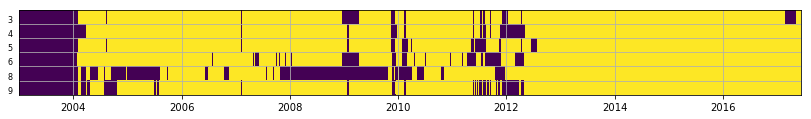

In [7]:
avail(t.notnull(), figsize=(14, 2), bottom=.4)

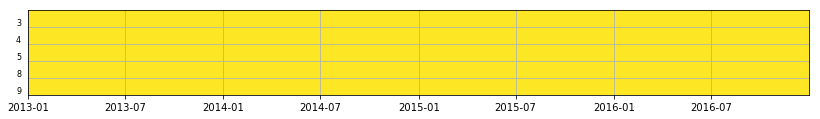

In [5]:
x = t[(t.index >= pd.Timestamp('2013')) & (t.index < pd.Timestamp('2017'))]
avail(x.notnull(), figsize=(14, 2), bottom=.4)

In [64]:
x.isnull().sum()

station
3    0
4    0
5    0
8    0
9    0
dtype: int64

In [53]:
def missing(shape, frac, blocks=0):
    mask = np.ones(x.shape).flatten()
    n = round(frac * len(mask))
    if blocks == 0:
        mask[np.random.randint(0, len(mask), n)] = np.nan
    else:
        s = np.random.poisson(n / blocks, blocks)
        i = np.random.randint(0, len(mask) - np.max(s), blocks)
        for j, t in zip(i, s):
            mask[j: j + t] = np.nan
    return np.reshape(mask, x.shape, {0: 'F', 1:'C'}[np.argmax(shape)])

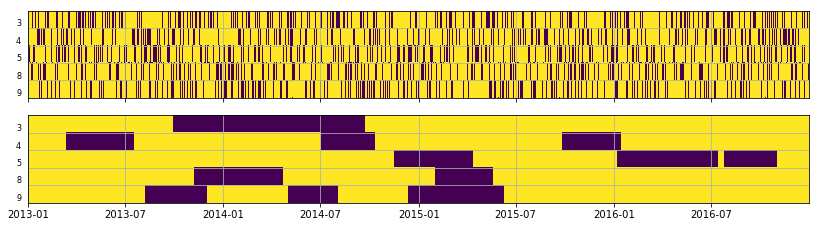

In [76]:
fig, axs = plt.subplots(2, 1, figsize=(14, 3))
avail((x*missing(x.shape, .3)).notnull(), axs[0])
avail((x*missing(x.shape, .3, 20)).notnull(), axs[1], bottom=.1)
axs[0].set_xticklabels([]);

In [78]:
from ppca import probPCA

In [80]:
p = probPCA(x.values.T).critique()

499/500 [ 99%] █████████████████████████████  ETA: 0s | t: 500.000 | loss: 11397.800tau 0.486884
[[ 14.29329491]
 [ 14.33711529]
 [ 14.45602226]
 [ 16.56104851]
 [ 14.146842  ]]
noisy input:  2008.04839832


In [81]:
x.mean()

station
3    14.293943
4    14.335553
5    14.454881
8    16.561107
9    14.146469
dtype: float64